# Introduction

In this notebook example, we will use `gemlib` to implement a spatial SIR model, where individuals have static locations in space, and become infected as a function of their spatial relationship to others around them.  Such a model is commonly used in livestock epidemiology for diseases such as foot and mouth disease.

We will implement the model using a combination of Tensorflow Probability and `gemlib`, a new library for epidemic analysis.

## Install `gemlib`

We'll start by installing the `gemlib` library direct from GitLab:

In [ ]:
%load_ext autoreload
%autoreload 2

from warnings import warn

try:
    import google.colab
    !pip install -Uq git+https://gitlab.com/gem-epidemics/gemlib.git
except:
    warn("Not running in Colab, make sure `gemlib` is installed locally")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 10.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


and now import the modules we need for this notebook...

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spp
from typing import NamedTuple

import tensorflow as tf
import tensorflow_probability as tfp

import gemlib
assert gemlib.__version__ == "0.10.1"
from gemlib.distributions import DiscreteTimeStateTransitionModel

tfd = tfp.distributions

%matplotlib inline

DTYPE=np.float32

## The population dataset

For the sake of argument, we'll simulate some spatial locations  in a 10km x 10km square to represent our population.  In the real world, of course, we would have a geospatial dataset containing coordinates which we could just as easily import here.

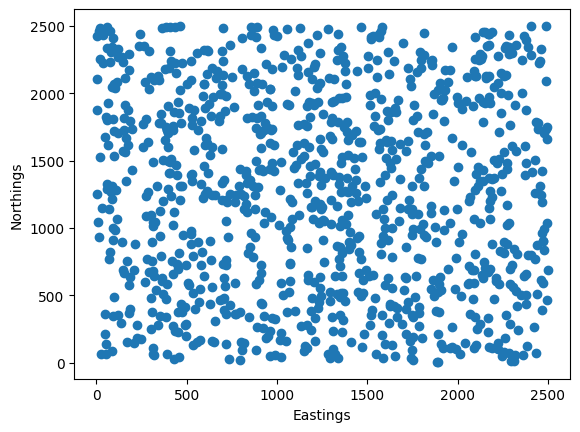

In [ ]:
popsize = 1000

coords = tfd.Uniform(low=DTYPE(0.0), high=DTYPE(2500.0)).sample(
    sample_shape=(popsize, 2), seed=[0,0]
).numpy()

plt.scatter(coords[:, 0], coords[:, 1])
plt.xlabel("Eastings")
_ = plt.ylabel("Northings")

## The epidemic model

We're going to model our epidemic using the time-honoured SIR model, where each individual starts as susceptible before becoming infected, and finally recovered with solid immunity.  Here, we have 3 _states_: $S$, $I$, and $R$ representing susceptible, infected, and recovered individuals respectively.

We'll use $x_t$ to represent the _global_ state (i.e. the configuration of S, E, I, and R states) of the epidemic at time $t$ , and say that $x^{q}_{it} = 1$ if and only if individual $i$ is in state $q$ at time $t$, and 0 otherwise.  

We have three transitions, $S \rightarrow E$, $E \rightarrow I$, and $I \rightarrow R$ for which we assume transition rates
\begin{align*}
\lambda^{SE}_i(t, x_t) &= \beta \sum_{j=1}^{N} K_{ij}(\alpha)(h_0x^{E}_{jt}+x^{I}_{jt})+\epsilon \\
\lambda^{EI}_i(t, x_t) &= \sigma \\
\lambda^{IR}_i(t, x_t) &= \gamma.
\end{align*}

We define $K(\alpha)$ to be a _spatial kernel_ function, which describes the rate at which the infection rate between two individuals, $i$ and $j$, decreases as a function of distance.  For simplicity, we'll assume here that
$$
K_{ij}(\alpha) = e^{-d_{ij}/\alpha}
$$
where $d_{ij}$ is the Euclidean (i.e. straight-line) distance between individuals $i$ and $j$.

### The distance matrix and kernel

We'll start by creating a function that computes a matrix $D=(d_{ij})$ such that $d_{ij}$ is the Euclidean distance between individuals $i$ and $j$, and implement a function that returns $K(\alpha)$.


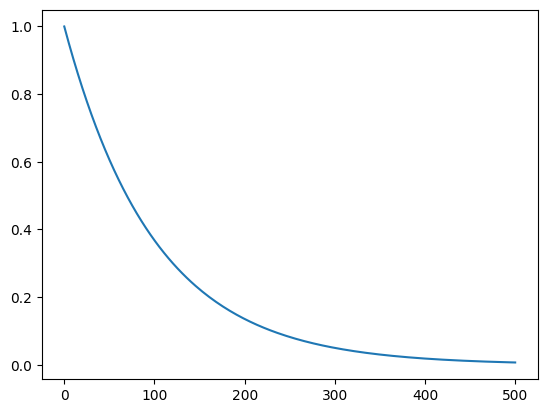

In [ ]:
D = spp.distance.squareform(spp.distance.pdist(coords)).astype(DTYPE)

def spatial_kernel(distance, alpha):
    return tf.math.exp(-distance/alpha)

# Plot the spatial kernel
def plot_spatial_kernel(alpha, low=0, high=500):
    x = np.linspace(low, high, 200)
    K = spatial_kernel(x, alpha)
    plt.plot(x, K)

plot_spatial_kernel(100)

Note that we're using Tensorflow maths operators inside our spatial kernel, since further on down we'll be using it inside Tensorflow-compiled code.

# Implementing the SEIR model in `gemlib`

Having specified our _states_, the _transitions_ between states, and the rates at which they occur, we can start to assemble a model for the disease process.  We'll do this using `gemlib`'s `DiscreteTimeStateTransitionModel`, which embeds the above model into a discrete-time state transition stochastic process.

There are 3 key ingredients to implementing a model:

* The _incidence matrix_ which describes the state transition graph
* The _initial state_ matrix describing the global state of the epidemic at the beginning
* The _transition rate function_ which, given the time and a global state, computes the transition rates for each individual along each transition.

## Incidence matrix

For the SEIR model we have 4 states `S, E, I, R` and 3 transitions `SE`, `EI` and `IR`. The incidence matrix is:

In [ ]:
incidence_matrix = np.array(
    [ #  SE  EI  IR
        [-1,  0,  0],  # S
        [ 1, -1,  0],  # E
        [ 0,  1, -1],  # I
        [ 0,  0,  1],  # R
    ],
    dtype=DTYPE
)

## Initial state

The initial state (or initial conditions) matrix describes the global state of the population at the start of the epidemic.

We represent this as a `[N, M]` _one-hot_ encoding for $N$ individuals and $M$ states.  Here, the _one-hot_ encoding means that for each individual (i.e. row), there is at most one 1 indicating the state in which the individual exists.

We'll start with individual id = 0 being infected, and everybody else susceptible.

In [ ]:
initial_state = np.concatenate(
    [
        [[0, 1, 0, 0]], # Initial infected
        np.repeat([[1, 0, 0, 0]], popsize-1, axis=0) # Everybody else susceptible
    ],
    axis=0,
).astype(DTYPE)

In [ ]:
type(initial_state)

numpy.ndarray

## Transition rate function

Now we need to express our transition rates, which we do by creating a function that returns a tuple of two arrays giving the transition rates between each state for each individual in the model.  Strict ordering of states and transition rates is maintained as for the incidence matrix above.

In [ ]:
def transition_rates(t, state):
    beta = DTYPE(0.23)
    sigma = DTYPE(1/4.0)
    gamma = DTYPE(1/4.41)
    epsilon = DTYPE(3.8e-4)
    alpha = DTYPE(100)
    h0 = DTYPE(0.03)

    se_rate = beta * tf.linalg.matvec(
        spatial_kernel(D, alpha), h0*state[:, 1] + state[:,2]
    ) + tf.fill((state.shape[0],), epsilon)
    ei_rate = tf.fill((state.shape[0],), sigma)
    ir_rate = tf.fill((state.shape[0],), gamma)

    return se_rate, ei_rate, ir_rate

As a check, let's make sure our transition rate function returns something sensible if supplied the initial state:

In [ ]:
test_rates = transition_rates(0.0, initial_state)
print("Test rate shapes:", [x.shape for x in test_rates])

Test rate shapes: [TensorShape([1000]), TensorShape([1000]), TensorShape([1000])]


which results in a tuple of three vectors of length $N$ as expected for the $S\rightarrow E$, $E \rightarrow I$, and $I \rightarrow R$ transitions respectively.

## The discrete-time model

Armed with the data structures and functions above, we can now instantiate the `DiscreteTimeStateTransitionModel`

In [ ]:
seir = DiscreteTimeStateTransitionModel(transition_rate_fn=transition_rates,
                                       incidence_matrix=incidence_matrix,
                                       initial_state=initial_state,
                                       initial_step=0,
                                       time_delta=1.0,
                                       num_steps=78)

and run a simulation using the `sample` method

In [ ]:
seir_sim = seir.sample(seed=[0, 0])

In [ ]:
seir_sim.shape

TensorShape([78, 1000, 3])

`sample()` spits out a tensor of dimension `[T, N, L]` for $T$ timesteps, $N$ individuals, and $L$ transitions.  This tensor, $Z$, such that $z^{qr}_{it} = 1$ if individual $i$ undergoes a transition from $q$ to $r$ at timestep $t$.

We can therefore compute the total number of each type of transition happening on each day by taking the sum across the second dimension  (i.e. $N$) of the tensor.  In the context of our SEIR model this is, of course, equivalent to plotting the daily absolute incidence of infection, symptom onset, and recovery events.

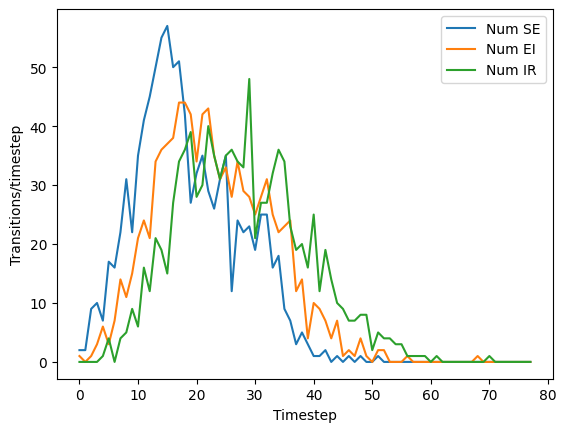

In [ ]:
plt.plot(np.sum(seir_sim, axis=1), label=["Num SE", "Num EI", "Num IR"])
plt.xlabel("Timestep")
plt.ylabel("Transitions/timestep")
plt.legend()

We can also use the `compute_state` method to recover the _state_ timeseries, if we wish to plot prevalence rather than incidence:



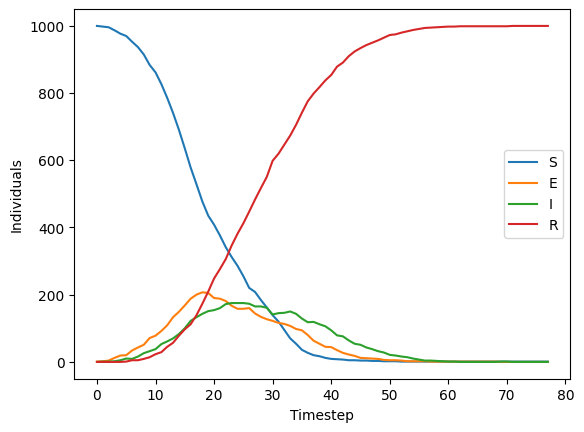

In [ ]:
seir_sim_state = seir.compute_state(seir_sim)
plt.plot(np.sum(seir_sim_state, axis=1), label=["S", "E", "I", "R"])
plt.xlabel("Timestep")
plt.ylabel("Individuals")
_ = plt.legend()

And plot a map of the people who ended up infected

Text(0, 0.5, 'Northings')

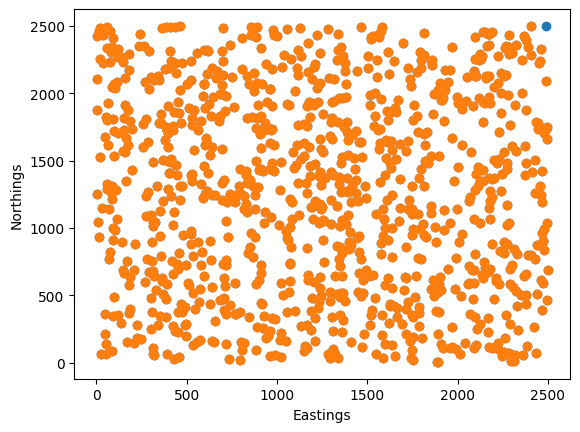

In [ ]:
infected_coords = coords[np.where(seir_sim_state[-1,:,3]==1.0)]
plt.scatter(coords[:, 0], coords[:, 1])
plt.scatter(infected_coords[:, 0], infected_coords[:, 1], label="infected")
plt.xlabel("Eastings")
plt.ylabel("Northings")

## Using Tensorflow for performance

You may have noticed that the simulation we have run above is not exactly snappy!  Since we're using Tensorflow, we can use the power of either Graph Mode or XLA compilation to accerate it.  All we need to do is wrap the call to `sir.sample()` in a decorated function.

Starting with graph mode compilation:

In [ ]:
# @tf.function
# def run_sir_sample_graph(seed):
#     return sir.sample(seed=seed)

# %time sir_sim_graph = run_sir_sample_graph(seed=[0,5])

NameError: in user code:

    File "<ipython-input-60-92c1e3922f3c>", line 3, in run_sir_sample_graph  *
        return sir.sample(seed=seed)

    NameError: name 'sir' is not defined


it's quite a bit faster!  Now let's try XLA compilation:

In [ ]:
# @tf.function(jit_compile=True)
# def run_sir_sample_xla(seed):
#     return sir.sample(seed=seed)

# %time sir_sim_xla = run_sir_sample_xla(seed=[0,5])

CPU times: user 21 s, sys: 477 ms, total: 21.5 s
Wall time: 28.1 s


Hmm.  That's slower!  Let's run it again...

In [ ]:
# %time sir_sim_xla = run_sir_sample_xla(seed=[0,5])

NameError: name 'run_sir_sample_xla' is not defined

That's quicker!  When we first ran our XLA-compiled function, it took time for the compiler to build the machine code required to implement the function.  When we ran it for a second time, the compilation had already been done so all that's left is the runtime.  Try running this notebook again using a GPU runtime, and see if you get any difference in speed...

<a name="log-lik-simple"></a>
## Log-likelihood computation

The last thing in this section that we'll look at is how to compute the probability of obtaining a given timeseries of transition events given the parameters, initial state, and indeed the model.  This is, of course, cruicial for inference, as we describe in the next section.

This is super-easy to compute, just using `DiscreteTimeStateTransitionModel`'s `log_prob` method.


In [ ]:
# sir.log_prob(sir_sim)

<tf.Tensor: shape=(), dtype=float32, numpy=-4192.8433>

# Inference

Now we have a working model (and simulated data), we can use it to construct a Bayesian model by specifying prior distributions for it.

Let our epidemic model be written as
$$
\mathbf{z} \sim \mbox{SIR}(\beta, \gamma, \phi, \mathbf{x}_0)
$$
where $\mathbf{z}$ is the output transition events tensor (`sir_sim` above), $\mathbf{x}_0$ is the initial state, and $\theta = \{\beta, \gamma,\phi\}$ are the parameters.  We place priors on the parameters such that
$$
\begin{align*}
\beta & \sim \mbox{Gamma}(0.1, 0.1) \\
\gamma & \sim \mbox{Gamma}(2, 8) \\
\phi & \sim \mbox{Gamma}(6, 10).
\end{align*}
$$


## Implementing a Bayesian model

To build this model, we essentially have to specify a probabilistic DAG.  In code, we do this by using the TensorFlow Probability `JointDistributionCoroutine` class.  

Notice that I've specified the entire model from scratch.  This is required because if we change the value of a parameter (as an optimiser or MCMC algorith will), then we need to re-instantiate the model with the new parameter value.

* Think about this in terms of the Bayesian DAG, and how we write probability distributions as above, to see why this is sensible.
* It's also computing best practice -- wrapping all the logic into functions guards against unexpected results due to global variables being changed when you're not looking!

In [ ]:
@tfd.JointDistributionCoroutine
def model():

    # Priors
    beta = yield tfd.Gamma(
        concentration=DTYPE(1.0), rate=DTYPE(1.0), name="beta",
    )
    sigma = yield tfd.Gamma(
        concentration=DTYPE(2.0), rate=DTYPE(8.0), name="sigma"
    )
    gamma = yield tfd.Gamma(
        concentration=DTYPE(2.0), rate=DTYPE(8.0), name="gamma"
    )
    epsilon = yield tfd.Gamma(
        concentration=DTYPE(1.0), rate=DTYPE(1.0), name="epsilon"
    )
    alpha = yield tfd.Gamma(
        concentration=DTYPE(1.0), rate=DTYPE(1/50.0), name="alpha"
    )
    h0 = yield tfd.Beta(
        concentration1=DTYPE(3.0), concentration0=DTYPE(97.0), name="h0"
    )

    # Epidemic model
    incidence_matrix = np.array(
        [ #  SE  EI  IR
            [-1,  0,  0],  # S
            [ 1, -1,  0],  # E
            [ 0,  1, -1],  # I
            [ 0,  0,  1],  # R
        ],
        dtype=DTYPE
    )

    initial_state = np.concatenate(
        [
            [[0, 1, 0, 0]], # Initial infected
            np.repeat([[1, 0, 0, 0]], popsize-1, axis=0) # Everybody else susceptible
        ],
        axis=0,
    ).astype(DTYPE)

    def transition_rates(t, state):
        se_rate = beta * tf.linalg.matvec(
            spatial_kernel(D, alpha), h0*state[:, 1] + state[:,2]
        ) + tf.fill((state.shape[0],), epsilon)
        ei_rate = tf.fill((state.shape[0],), sigma)
        ir_rate = tf.fill((state.shape[0],), gamma)

        return se_rate, ei_rate, ir_rate

    seir = yield DiscreteTimeStateTransitionModel(
        transition_rate_fn=transition_rates,
        incidence_matrix=incidence_matrix,
        initial_state=initial_state,
        initial_step=0,
        time_delta=1.0,
        num_steps=78,
        name="seir"
    )

## Prior simulation

So we now have an instantiated model, but what can we do with it? The first thing we might like to do is to simulate from the _prior_ model.  That is, draw the parameters from their respective prior distributions, plugging the resulting values into the SIR model and then simulating from it.  In other words, we start at the top of the DAG, and work our way downwards.

Given we've set up a `JointDistributionCoroutine`, this is very simple!  We just call the `sample()` method with a seed, and obtain a `StructTuple` of values for each of the distributions in our model.  TFP automatically takes care of drawing from the distributions in the correct order.

In [ ]:
prior_sim = model.sample(seed=[0,4])

We can refer to the elements of the `StructTuple` using dot notation, for example

In [ ]:
prior_sim.beta

<tf.Tensor: shape=(), dtype=float32, numpy=1.9247805>

## Conditioning the model

Of course, simulating from the prior distributions is not guaranteed to give us any sensible epidemic simulation output, as there is nothing constraining the parameters to be consistent with the data other than our _a priori_ belief about their values.  Even if we specified carefully chosen marginal prior distributions for the parameters, there is nothing stopping us simulating combinations of parameters that lead to non-sensical epidemic output.  

What we need to do is _condition_ the model on having observed some epidemic output, and then find a way to work out the joint _a posteriori_ distribution of the parameters in the light of these observations.  

Bayes' Theorem tells us that
$$
Pr(\theta | Z, \mathbf{x_0}) = \frac{Pr(Z | \theta, \mathbf{x}_0)Pr(\theta)}{\int_{\Theta} Pr(Z | \theta, \mathbf{x_0})Pr(\theta) \mathrm{d}\theta}
$$
where $Pr(\theta | \mathbf{z}, \mathbf{x}_0)$ is the _posterior distribution_, $Pr(\mathbf{z} | \theta, \mathbf{x}_0)$ is the probability of observing the transition event timeseries $\mathbf{z}$ given the parameters and initial state, i.e. the likelihood, $Pr(\theta)$ is the (joint) prior distribution of the parameters.

In computing, conditioning a model is essentially the same as fixing the value of a given function argument, which TFP allows us to do with the `experimental_pin` method:

In [ ]:
conditioned_model = model.experimental_pin(seir=seir_sim, sigma=1/4.0, gamma=1/4.41, alpha=100, h0=0.03)

With a conditioned model, we can no longer sample from the "upstream" distributions, since the standard samplers we would use for, say, the Gamma-distributed $\beta$ parameter are no longer guaranteed to give us samples in the right proportions for the _posterior_ distribution.  

Following this, `conditioned_model` has no `sample()` method.  However, we _can_ compute it's log probability given values for the remaining parameters.  Essentially, this gives us values for the _log posterior distribution_ up to an additive constant.

For example

In [ ]:
conditioned_model.log_prob(beta=0.23, epsilon = 3.8e-4)

<tf.Tensor: shape=(), dtype=float32, numpy=-7458.033>

The fact that we know this distribution only up to a constant is the reason we employ methods such as MCMC to draw samples from, and hence estimate, posterior distributions in all but the simplest of cases.  Readers are referred to the following texts for an in-depth discussion of these foundational principles:

* Gilks, W., Richardson, S.,, Spiegelhalter, D. (1995). Markov Chain Monte Carlo in Practice. Taylor & Francis. ISBN: 9780412055515
* Gelman, A., Carlin, J.B., Stern, H.S., Dunson, D.B., Vehtari, A., & Rubin, D.B. (2013). Bayesian Data Analysis (3rd ed.). Chapman and Hall/CRC. https://doi.org/10.1201/b16018

## Simple parameter inference

In this section, we'll use TFP to build an MCMC sampler to sample from the _joint posterior distribution_ of the parameters assuming that the transition event timeseries is fully known.

We will make use of TFP's adaptive Hamiltonian Monte Carlo MCMC sampler here, building up layers around a base HMC sampler.

In [ ]:
# Based HMC algorithm
base_hmc_kernel = tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(
    target_log_prob_fn=conditioned_model.unnormalized_log_prob,
    step_size=0.01,
    num_leapfrog_steps=16,
    store_parameters_in_results=True,
)

# Adapt the step size
step_size_adapt = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=base_hmc_kernel,
    num_adaptation_steps=500,
)

# Adapt the mass matrix -- here we need to set up a RunningVariance
# that continually updates the estimate of the posterior variance
initial_running_variance = tf.nest.map_structure(
    lambda x: tfp.experimental.stats.RunningVariance.from_stats(
        DTYPE(1.0), mean=DTYPE(0.0), variance=DTYPE(1.0),
    ),
    conditioned_model.sample_unpinned(seed=[0,1]),
)
mass_matrix_adapt = tfp.experimental.mcmc.DiagonalMassMatrixAdaptation(
    inner_kernel=step_size_adapt,
    initial_running_variance=initial_running_variance,
    num_estimation_steps=450,
)

# The outer layer is a transformation layer that "unconstrains" the 0-bounded
# parameter space, and allows the HMC to work on the unbounded space it needs.
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=mass_matrix_adapt,
    bijector=conditioned_model.experimental_default_event_space_bijector(),
)

Then we create an XLA-compiled function that runs the MCMC, using TFP's `sample_chain` function.  This returns a data structure of samples from the joint posterior distibution, together with a data structure containing various sampler diagnostic we might be interested in.

In [ ]:
@tf.function(jit_compile=True)
def sample_chain(num_results, current_state, seed=[0,0]):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=current_state,
        kernel=kernel,
        seed=seed
)

Finally, we run the sampler and plot some traceplots.

In [ ]:
samples, results = sample_chain(
    num_results=5000,
    current_state=conditioned_model.sample_unpinned(seed=[0,1]),
    seed=[0,2],
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


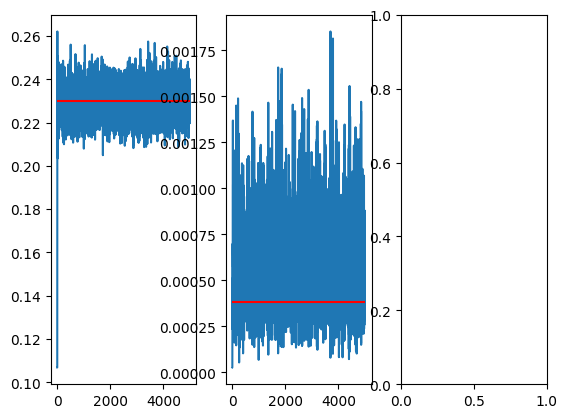

In [ ]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(samples.beta)
ax[0].hlines(xmin=0, xmax=samples.beta.shape[0], y=0.23, color="red")
ax[1].plot(samples.epsilon)
ax[1].hlines(xmin=0, xmax=samples.beta.shape[0], y=3.8e-4, color="red")
# ax[2].plot(samples.alpha)
# ax[2].hlines(xmin=0, xmax=samples.beta.shape[0], y=1/4.41, color="red")

# Inference with censored transition events

In practice, of course, we can only partially observe the epidemic process.  For this example, we'll assume that we observe recovery (or removal) times, but don't observe infection ($S \rightarrow E$) transitions.

What we now need is a method for treating $S \rightarrow E$ transitions as censored data, which in a Bayesian context means treating them as parameters to be estimated.  `gemlib` comes with an MCMC kernel to do this, and a method for using it in concert with the Hamiltonian MCMC sampler above in a so-called _Metropolis-within-Gibbs_ scheme.

To set this up, we need to embed our MCMC kernels into _builder_ functions that allow kernels to be constructed on the fly.  This is required because each kernel updates its parameter of interest (either $\theta$ or the $S \rightarrow E$ transitions) conditional on the rest of the parameters.  As we saw above, whenever we condition on parameters, we need to transform the log probability function -- the kernel builder functions handle this for us.  These builder functions can then be composed to give the resulting Metropolis-within-Gibbs kernel.

## Defining the MCMC kernel builder functions

In the following sections, we define a series of kernel builder functions we need to use a combination of the TFP Hamiltonian Monte Carlo (HMC) sampler and the `gemlib` kernel that updates censored transition events.  We take each in turn, before combining them into a single logical kernel.

### Adaptive HMC kernel

Here, we establish a `RunningVariance` object that will track the covariance of the evolving joint marginal posterior distribution of the parameters.  We then close over this as part of our kernel builder function.

Note that the initial running variance is used only once.  Subsequent `RunningVariance` objects are passed from one kernel invocation to the other in the `results` data structure thanks to the `store_parameters_in_results=True` option below.  

In [ ]:
example_params = model.experimental_pin(seir=seir_sim, sigma=1/4.0, gamma=1/4.41, alpha=100.0, h0=0.03).sample_unpinned(seed=[0,0])

# Each state part needs its own running variance object
initial_running_variance = tf.nest.map_structure(
    lambda x: tfp.experimental.stats.RunningVariance.from_stats(
        num_samples=tf.constant(1.0, DTYPE),
        mean=tf.constant(0.0, DTYPE),
        variance=tf.constant(1.0, DTYPE),
    ),
    example_params
)

bijector = tfp.bijectors.JointMap(
    tf.nest.map_structure(lambda x: tfp.bijectors.Exp(), example_params)
)


def build_hmc(conditional_posterior, current_state):
    """HMC builder

    Args
    ----
        conditional_posterior: an instance of JointDistributionPinned
        current_state: the _full_ MCMC state (not just the state part
                       that the kernel operates on)

    Returns
    -------
       a TransitionKernel object
    """

    base_hmc_kernel = tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(
        target_log_prob_fn=conditional_posterior.unnormalized_log_prob,
        step_size=DTYPE(0.1),
        num_leapfrog_steps=16,
        store_parameters_in_results=True,
    )

    adaptive_kernel = tfp.experimental.mcmc.DiagonalMassMatrixAdaptation(
        inner_kernel=tfp.mcmc.DualAveragingStepSizeAdaptation(
            inner_kernel=base_hmc_kernel,
            num_adaptation_steps=500,
        ),
        initial_running_variance=initial_running_variance,
        num_estimation_steps=450,
    )

    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=adaptive_kernel,
        bijector=bijector,
    )

    return kernel

### Move infection times

The following kernel updates partially-observed infection transitions: those that are known to have occurred at an unknown time.  This is used when we've observed a complete epidemic (as we have in `seir_sim`).

In [ ]:
from gemlib.mcmc.discrete_time_state_transition_model import UncalibratedEventTimesUpdate
from gemlib.mcmc.discrete_time_state_transition_model import TransitionTopology

def build_event_times_mh(conditional_posterior, current_state):
    return tfp.mcmc.MetropolisHastings(
        inner_kernel=UncalibratedEventTimesUpdate(
            target_log_prob_fn=conditional_posterior.unnormalized_log_prob,
             incidence_matrix=incidence_matrix,
            initial_conditions=initial_state,
            target_transition_id=0,
            delta_max=5,
            num_units=1,
            count_max=1,
        ),
    )

### Repeating invocations of the infection time move

We now establish a builder that wraps `build_event_times_mh` and allows it to be invoked multiple times per invocation of the HMC for the parameters.

In [ ]:
from gemlib.mcmc import MultiScanKernel

def build_multi_events(conditional_posterior, current_state):
    return MultiScanKernel(
        num_updates=100,  # Roughly 10% of the infections
        inner_kernel=build_event_times_mh(conditional_posterior, current_state),
)

## Composing the kernel builder functions

We now draw our kernels together into a `CompoundKernel` object, which is itself an MCMC kernel but encapsulates a sequential application of the component kernels.

In [ ]:
from gemlib.mcmc import CompoundKernel

component_kernels = (
    CompoundKernel.Step(varnames=("beta", "epsilon"), build=build_hmc),
    CompoundKernel.Step(varnames=("seir"), build=build_multi_events),
)

kernel = CompoundKernel(joint_model=model, kernels=component_kernels)

## Running the MCMC algorithm

As before, we make use of `sample_chain` to actually run the MCMC.  This involves:

1. constructing a starting position for the MCMC, and ensuring we
   get a finite log posterior density value at that position.
2. Constructing the MCMC kernel
3. Building a XLA-compiled MCMC algorithm

In [ ]:
# Create an initial position by creating a StructTuple
initial_position = prior_sim.__class__( # This is a hack to access the
    beta=DTYPE(0.1),                    # relevant StructTuple constructor
    sigma=DTYPE(1/4.0),
    gamma=DTYPE(1/4.41),
    epsilon=DTYPE(1e-4),
    alpha=100.0,
    h0=0.03,
    seir=seir_sim  # Our example epidemic from earlier
)

# Build a compiled version of sample_chain
@tf.function(jit_compile=True)
def sample_chain(num_results, current_state, seed=(0, 0)):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        kernel=kernel,
        current_state=current_state,
        seed=seed,
    )

And then invoke `sample_chain` to run the MCMC

In [ ]:
%time samples, results = sample_chain(5000, initial_position, seed=(0, 3))

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:273: UserWarning: Batched event times updates are not supported.  Using first event item only.
  pkr = self.inner_kernel.bootstrap_results(init_state)
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:273: UserWarning: Batched event times updates are not supported.  Using first event item only.
  pkr = self.inner_kernel.bootstrap_results(init_state)
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:191: UserWarning: Batched event times u

CPU times: user 10min 34s, sys: 2min 23s, total: 12min 58s
Wall time: 12min 27s


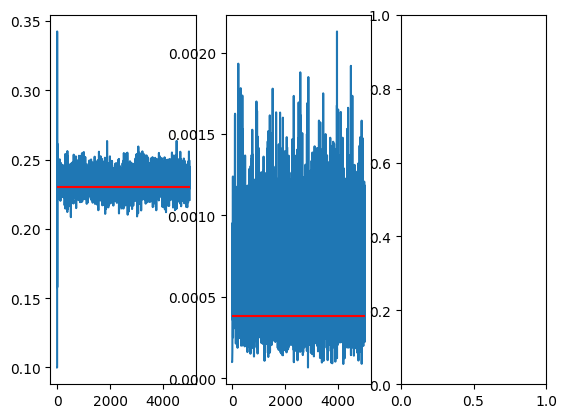

In [ ]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(samples.beta)
ax[0].hlines(xmin=0, xmax=samples.beta.shape[0], y=0.23, color="red")
ax[1].plot(samples.epsilon)
ax[1].hlines(xmin=0, xmax=samples.beta.shape[0], y=3.8e-4, color="red")
# ax[2].plot(samples.alpha)
# ax[2].hlines(xmin=0, xmax=samples.beta.shape[0], y=1.4, color="red")

Let's plot a heatmap of when all the $S \rightarrow E$ transitions happened for a particular iteration of the MCMC

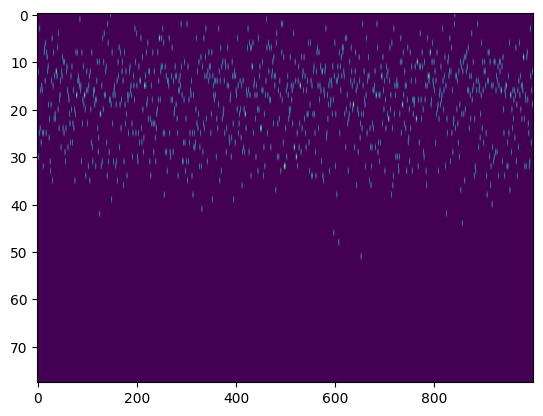

In [ ]:
plt.imshow(samples.seir[500,:,:,0], aspect="auto")

To get a traceplot of an individual's $S\rightarrow E$ transition time, we can employ a trick with a cumsum and a sum

In [ ]:
range(0,5000,10)

range(0, 5000, 10)

In [ ]:
samples.seir[:,10:15,100,0]

<tf.Tensor: shape=(5000, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>

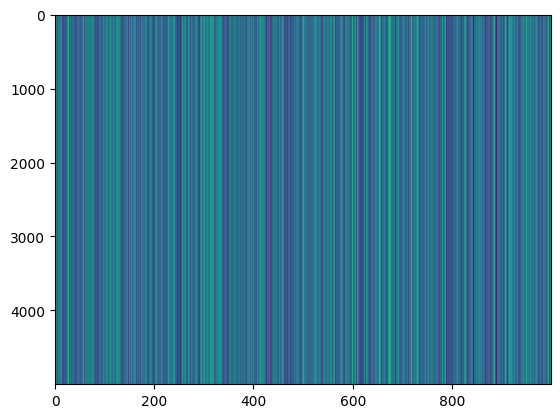

In [ ]:
plt.imshow(tf.reduce_sum(tf.cumsum(samples.seir[:,:,:,0], axis=-2, reverse=True), axis=-2), aspect="auto")

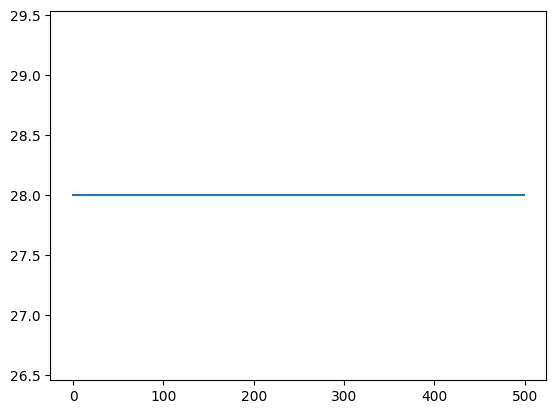

In [ ]:
# Raw traceplots of shape [K, T, N, L] for K MCMC iterations, T timepoints,
# N individuals and L transitions.  We take a reverse cumsum and a sum across the T
# dimension to get the time of the SE event for each individual.
se_traceplots = tf.reduce_sum(tf.cumsum(samples.seir[0:5000:10,:,:,:], axis=-3, reverse=True), axis=-3)

# The resulting traceplot is of shape [K, N, L], so we
# plot the SE (L=0) traceplot for individual id=5 (N=5)
plt.plot(se_traceplots[:,900, 0])

In [ ]:
se_traceplots

<tf.Tensor: shape=(1, 1000, 3), dtype=float32, numpy=
array([[[ 0.,  1., 12.],
        [18., 23., 31.],
        [13., 15., 18.],
        ...,
        [17., 32., 34.],
        [20., 21., 23.],
        [13., 14., 15.]]], dtype=float32)>